# ตอนที่ 1: การทดลองเตรียมข้อมูล ปรับค่าข้อมูล และจัดแบ่งชุด Train, Test เพื่อสอนโมเดล

1.1 Import Lib (numpy, pandas, matplotlib, sklearn, keras)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn import model_selection
from sklearn import preprocessing
import seaborn as sns
from scipy import stats

Using TensorFlow backend.


1.2 โหลดข้อมูล Timeseries Dataset file

In [2]:
df_Beijing = pd.read_csv('BeijingPM20100101_20151231.csv')
df_Chengdu = pd.read_csv('ChengduPM20100101_20151231.csv')
df_Guangzhou = pd.read_csv('GuangzhouPM20100101_20151231.csv')
df_Shanghai = pd.read_csv('ShanghaiPM20100101_20151231.csv')
df_Shenyang = pd.read_csv('ShenyangPM20100101_20151231.csv')

1.3 Preprocess data

    1.3.1 Cleaning : Clear Missing and Duplicate data, Resampling and interpolated data, Moving average (Rolling window)

    1.3.2 แสดงรูปภาพเปรียบเทียบข้อมูลก่อนและหลัง Cleaning

In [3]:
def pm2_5_level(df):
    if df['PM_US Post']<10:
        return 0
    elif df['PM_US Post'] <= 25:
        return 1
    elif df['PM_US Post'] > 25:
        return 2
    else: 
        return np.nan

In [4]:
def show_graph(msg,df,setX=True):
    hist = df.hist(bins=8,figsize=(10,10))
    
    axes = df.plot.line(x='Date',subplots=True, figsize=(16, 16),title=msg)
    
    list_of_cmaps=['Blues','Greens','Reds','Purples']
    
    g = sns.PairGrid(df ,hue='PM2.5_level', hue_kws={"cmap":list_of_cmaps},)
    g.map_upper(plt.scatter)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.distplot)
    g.add_legend()

In [5]:
def before_cleaning(data):
    start_col=['year','month','day','hour','HUMI','PRES','Iws','Iprec','PM_US Post']
    df = pd.DataFrame(data,columns=start_col)
    
    df['Date'] = pd.to_datetime(df[['year','month','day','hour']])
    df.sort_values('Date', inplace=True)
    
    df.dropna(subset=['PM_US Post'],inplace=True) # drop pm 2.5 missing values
    df['PM2.5_level'] = df.apply(lambda df:pm2_5_level(df),axis=1) # add col 'PM2.5_level'
    
    df = df[['Date','HUMI','PRES','Iws','Iprec','PM_US Post','PM2.5_level']]
    _df = df.copy()
    
    _df.dropna(inplace=True)
    
    # show_graph(msg='Before',df=_df)
    
    return df

In [6]:
def clear_missing_and_duplicate_data(df):
    
    df[df.columns[1:4]] = df[df.columns[1:4]].apply(pd.to_numeric, errors='coerce')
    
    df = df.fillna(df.median()) # จัดการข้อมูลหาย แทนที่ด้วย median
    df = df.drop_duplicates()
    
    return df

In [7]:
def find_timediff(df):
    df['timediff'] = (df['Date']-df['Date'].shift().shift()).fillna(0)
    print('median timediff : ',df['timediff'].median())
    return df

In [8]:
def resample_rolling(df,resample='2H'):
    
    df = df.set_index('Date').resample(resample).mean()
    df.sort_values('Date', inplace=True)
    
    df.interpolate(inplace=True)
    df = df.rolling(5).mean()
    
    df = df.reset_index()
    df = df.iloc[4:,:6]
    
    df['PM2.5_level'] = df.apply(lambda df:pm2_5_level(df),axis=1).astype(np.uint8)
    
    df = df[['Date','HUMI','PRES','Iws','Iprec','PM_US Post','PM2.5_level']]

    # show_graph(msg="After",df=df,setX=False)
    return df

In [9]:
df1 = before_cleaning(data=df_Beijing)
df1

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
23,2010-01-01 23:00:00,41.0,1020.0,0.89,0.0,129.0,2
24,2010-01-02 00:00:00,38.0,1020.0,1.79,0.0,148.0,2
25,2010-01-02 01:00:00,42.0,1020.0,2.68,0.0,159.0,2
26,2010-01-02 02:00:00,63.5,1021.0,3.57,0.0,181.0,2
27,2010-01-02 03:00:00,85.0,1022.0,5.36,0.0,138.0,2
28,2010-01-02 04:00:00,85.0,1022.0,6.25,0.0,109.0,2
29,2010-01-02 05:00:00,92.0,1022.0,7.14,0.0,105.0,2
30,2010-01-02 06:00:00,92.0,1023.0,8.93,0.0,124.0,2
31,2010-01-02 07:00:00,85.0,1024.0,10.72,0.0,120.0,2
32,2010-01-02 08:00:00,85.0,1024.0,12.51,0.0,132.0,2


In [10]:
df1 = clear_missing_and_duplicate_data(df=df1)
df1

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
23,2010-01-01 23:00:00,41.0,1020.0,0.89,0.0,129.0,2
24,2010-01-02 00:00:00,38.0,1020.0,1.79,0.0,148.0,2
25,2010-01-02 01:00:00,42.0,1020.0,2.68,0.0,159.0,2
26,2010-01-02 02:00:00,63.5,1021.0,3.57,0.0,181.0,2
27,2010-01-02 03:00:00,85.0,1022.0,5.36,0.0,138.0,2
28,2010-01-02 04:00:00,85.0,1022.0,6.25,0.0,109.0,2
29,2010-01-02 05:00:00,92.0,1022.0,7.14,0.0,105.0,2
30,2010-01-02 06:00:00,92.0,1023.0,8.93,0.0,124.0,2
31,2010-01-02 07:00:00,85.0,1024.0,10.72,0.0,120.0,2
32,2010-01-02 08:00:00,85.0,1024.0,12.51,0.0,132.0,2


In [11]:
# find_timediff(df=df1)
df1 = resample_rolling(df=df1)
df1

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2010-01-02 06:00:00,66.45,1021.4,4.822,0.000000e+00,134.2,2
5,2010-01-02 08:00:00,75.25,1022.3,7.325,0.000000e+00,135.6,2
6,2010-01-02 10:00:00,83.65,1023.5,10.677,0.000000e+00,134.9,2
7,2010-01-02 12:00:00,84.60,1024.3,14.924,0.000000e+00,135.2,2
8,2010-01-02 14:00:00,81.50,1024.9,20.333,0.000000e+00,145.1,2
9,2010-01-02 16:00:00,79.00,1025.5,26.055,0.000000e+00,154.1,2
10,2010-01-02 18:00:00,77.80,1026.1,32.045,0.000000e+00,157.2,2
11,2010-01-02 20:00:00,78.40,1026.4,37.767,0.000000e+00,159.2,2
12,2010-01-02 22:00:00,79.60,1026.8,43.400,0.000000e+00,148.6,2
13,2010-01-03 00:00:00,82.70,1027.1,48.677,1.300000e-01,130.1,2


In [12]:
df2 = before_cleaning(data=df_Chengdu)
df2 = clear_missing_and_duplicate_data(df=df2)
df2 = resample_rolling(df=df2)
df2

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2012-05-14 22:00:00,24.740312,1013.854687,2.015625,0.000000e+00,46.179688,2
5,2012-05-15 00:00:00,24.990469,1013.832031,2.023438,0.000000e+00,46.269531,2
6,2012-05-15 02:00:00,25.240625,1013.809375,2.031250,0.000000e+00,46.359375,2
7,2012-05-15 04:00:00,25.490781,1013.786719,2.039062,0.000000e+00,46.449219,2
8,2012-05-15 06:00:00,25.740937,1013.764063,2.046875,0.000000e+00,46.539062,2
9,2012-05-15 08:00:00,25.991094,1013.741406,2.054688,0.000000e+00,46.628906,2
10,2012-05-15 10:00:00,26.241250,1013.718750,2.062500,0.000000e+00,46.718750,2
11,2012-05-15 12:00:00,26.491406,1013.696094,2.070312,0.000000e+00,46.808594,2
12,2012-05-15 14:00:00,26.741562,1013.673437,2.078125,0.000000e+00,46.898438,2
13,2012-05-15 16:00:00,26.991719,1013.650781,2.085938,0.000000e+00,46.988281,2


In [13]:
df3 = before_cleaning(data=df_Guangzhou)
df3 = clear_missing_and_duplicate_data(df=df3)
df3 = resample_rolling(df=df3)
df3

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2011-11-21 20:00:00,70.2000,1012.950000,5.27000,0.000000e+00,75.00,2
5,2011-11-21 22:00:00,72.4875,1012.868750,3.64125,0.000000e+00,83.05,2
6,2011-11-22 00:00:00,73.6625,1013.056250,3.32375,0.000000e+00,86.55,2
7,2011-11-22 02:00:00,74.2250,1013.312500,3.02750,0.000000e+00,87.00,2
8,2011-11-22 04:00:00,73.3750,1013.437500,3.51250,0.000000e+00,84.50,2
9,2011-11-22 06:00:00,71.3125,1013.381250,4.26875,0.000000e+00,80.75,2
10,2011-11-22 08:00:00,69.2500,1013.325000,5.02500,0.000000e+00,77.00,2
11,2011-11-22 10:00:00,67.1875,1013.268750,5.78125,0.000000e+00,73.25,2
12,2011-11-22 12:00:00,65.1250,1013.212500,6.53750,0.000000e+00,69.50,2
13,2011-11-22 14:00:00,62.7750,1012.747500,8.07250,0.000000e+00,66.00,2


In [14]:
df4 = before_cleaning(data=df_Shanghai)
df4 = clear_missing_and_duplicate_data(df=df4)
df4 = resample_rolling(df=df4)
df4

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2011-12-29 02:00:00,72.804,1027.90,16.1,0.000000e+00,33.5,2
5,2011-12-29 04:00:00,75.626,1028.00,20.7,0.000000e+00,32.5,2
6,2011-12-29 06:00:00,75.588,1028.10,26.0,0.000000e+00,31.7,2
7,2011-12-29 08:00:00,74.067,1028.50,32.1,0.000000e+00,34.5,2
8,2011-12-29 10:00:00,71.248,1028.90,39.1,0.000000e+00,36.6,2
9,2011-12-29 12:00:00,66.298,1029.20,48.0,0.000000e+00,37.2,2
10,2011-12-29 14:00:00,62.633,1029.30,57.6,0.000000e+00,38.7,2
11,2011-12-29 16:00:00,61.238,1029.40,68.3,0.000000e+00,43.0,2
12,2011-12-29 18:00:00,61.195,1029.62,80.0,0.000000e+00,56.9,2
13,2011-12-29 20:00:00,63.929,1029.84,92.5,0.000000e+00,71.9,2


In [15]:
df5 = before_cleaning(data=df_Shenyang)
df5 = clear_missing_and_duplicate_data(df=df5)
df5 = resample_rolling(df=df5)
df5

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2013-04-22 20:00:00,25.9340,1012.80,46.40,0.000000e+00,105.20,2
5,2013-04-22 22:00:00,25.9560,1012.70,42.10,0.000000e+00,101.30,2
6,2013-04-23 00:00:00,25.9780,1012.60,37.80,0.000000e+00,97.40,2
7,2013-04-23 02:00:00,26.0000,1012.50,33.50,0.000000e+00,93.50,2
8,2013-04-23 04:00:00,26.0220,1012.40,29.20,0.000000e+00,89.60,2
9,2013-04-23 06:00:00,26.0440,1012.30,24.90,0.000000e+00,85.70,2
10,2013-04-23 08:00:00,26.0660,1012.20,20.60,0.000000e+00,81.80,2
11,2013-04-23 10:00:00,26.1706,1012.02,18.76,0.000000e+00,76.68,2
12,2013-04-23 12:00:00,26.1638,1011.56,20.68,0.000000e+00,77.44,2
13,2013-04-23 14:00:00,28.9576,1010.92,26.16,0.000000e+00,80.68,2


In [16]:
df_all = [df1,df2,df3,df4,df5]

df = pd.concat(df_all)
df

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2010-01-02 06:00:00,66.450,1021.4,4.822,0.000000e+00,134.2,2
5,2010-01-02 08:00:00,75.250,1022.3,7.325,0.000000e+00,135.6,2
6,2010-01-02 10:00:00,83.650,1023.5,10.677,0.000000e+00,134.9,2
7,2010-01-02 12:00:00,84.600,1024.3,14.924,0.000000e+00,135.2,2
8,2010-01-02 14:00:00,81.500,1024.9,20.333,0.000000e+00,145.1,2
9,2010-01-02 16:00:00,79.000,1025.5,26.055,0.000000e+00,154.1,2
10,2010-01-02 18:00:00,77.800,1026.1,32.045,0.000000e+00,157.2,2
11,2010-01-02 20:00:00,78.400,1026.4,37.767,0.000000e+00,159.2,2
12,2010-01-02 22:00:00,79.600,1026.8,43.400,0.000000e+00,148.6,2
13,2010-01-03 00:00:00,82.700,1027.1,48.677,1.300000e-01,130.1,2


    1.3.3 Normalizing data

In [17]:
def min_max_norm(df):
    _df = df.iloc[:,1:5]
    print(_df)
    x = _df.values #returns a numpy array
    
    pm = df['PM2.5_level'].values
   
    min_max_scaler = preprocessing.MinMaxScaler() # Max-Min Norm
    x_min_max_scaled = min_max_scaler.fit_transform(x)
    
    _df = pd.DataFrame(x_min_max_scaled,columns=['HUMI','PRES','Iws','Iprec'])
    _df.plot(figsize=(16, 10))
    
    _df['PM2.5_level'] = pm
    return _df

         HUMI    PRES      Iws         Iprec
4      66.450  1021.4    4.822  0.000000e+00
5      75.250  1022.3    7.325  0.000000e+00
6      83.650  1023.5   10.677  0.000000e+00
7      84.600  1024.3   14.924  0.000000e+00
8      81.500  1024.9   20.333  0.000000e+00
9      79.000  1025.5   26.055  0.000000e+00
10     77.800  1026.1   32.045  0.000000e+00
11     78.400  1026.4   37.767  0.000000e+00
12     79.600  1026.8   43.400  0.000000e+00
13     82.700  1027.1   48.677  1.300000e-01
14     85.900  1026.9   54.445  4.800000e-01
15     88.500  1026.2   60.748  1.210000e+00
16     89.200  1025.5   67.809  2.280000e+00
17     89.900  1024.7   75.406  3.590000e+00
18     89.200  1023.9   83.449  4.970000e+00
19     87.800  1022.9   91.761  6.450000e+00
20     86.400  1022.1  100.611  7.710000e+00
21     85.700  1021.3  109.284  8.730000e+00
22     85.000  1020.9   91.181  9.630000e+00
23     86.400  1020.9   72.230  8.120000e+00
24     87.100  1021.4   53.010  6.290000e+00
25     84.

,HUMI,PRES,Iws,Iprec,PM2.5_level
0,0.991698,0.637854,0.007284,0.000000e+00,2
1,0.993876,0.651267,0.011065,0.000000e+00,2
2,0.995954,0.669151,0.016128,0.000000e+00,2
3,0.996189,0.681073,0.022544,0.000000e+00,2
4,0.995422,0.690015,0.030715,0.000000e+00,2
5,0.994804,0.698957,0.039358,0.000000e+00,2
6,0.994507,0.707899,0.048406,0.000000e+00,2
7,0.994655,0.712370,0.057050,0.000000e+00,2
8,0.994952,0.718331,0.065559,0.000000e+00,2
9,0.995719,0.722802,0.073530,1.300010e-06,2


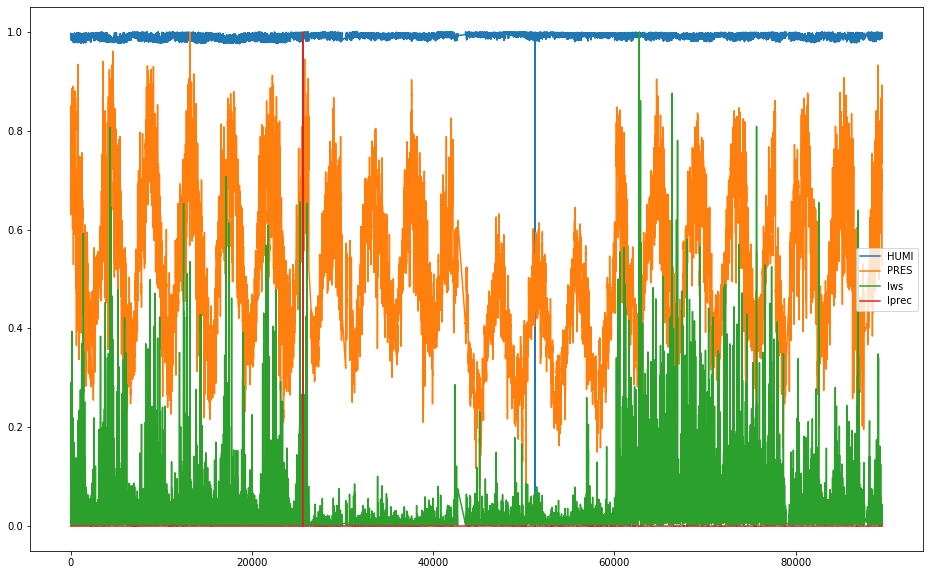

In [18]:
df_norm = min_max_norm(df=df)
df_norm

    1.3.4 Convert sample-based data to timeseries data format

In [19]:
Timestep = 10
Timestride = 1
n_feature = 4
labels = np.array([0, 1, 2])

def create_WindowTimeSeries(label,df,time_step,n_feature,time_stride):
    df_series = df[df['PM2.5_level'] == label].iloc[:,:-1]
    segments = []
    labels = []
    for i in range(0,len(df_series) - time_step, time_stride):
        df_series_feature = df_series.iloc[i: i + time_step,:n_feature]
        segments.append(np.array(df_series_feature))
        labels = np.append(labels,label)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_step, n_feature,1)
    return reshaped_segments, labels

# x = []
# y = []

# for i in range(0,len(df)-Timestep,Timestride):
#     feature = df.iloc[i:i+Timestep,:4].to_numpy()
#     label = df.iloc[i:i+Timestep,4:5].to_numpy()
    

In [20]:
def get_2D_Features_XandGroundTruth_Y(df):
    x = []
    y = []
    for label in labels:
        _x , _y = create_WindowTimeSeries(label=label, df=df, time_step=Timestep,
                                         n_feature=n_feature, time_stride=Timestride)
        x.append(_x)
        y.append(_y)
    x = np.concatenate(x)
    y = np.concatenate(y)
    return x, y
X_2D, y_2D = get_2D_Features_XandGroundTruth_Y(df=df_norm)

In [21]:
X_2D.shape

(89539, 10, 4, 1)

1.4 Prepare Label Ground Truth (y) สำหรับแต่ละชุด timeseries ด้วย majority vote และ ทำ One-Hot Encoding โดยจัดข้อมูล ground truth จาก 1D -> binary N-D class เช่น ข้อมูลเดิม y มี 3 class (1,2,3) ให้จัดรูปแบบ y ใหม่ เป็น binary output ซึ่งให้ค่า ตำแหน่ง class คำตอบที่ถูกต้องเป็น 1 สำหรับ class ที่ผิดที่เหลือจะมีค่าเป็น 0 โดยใช้

In [22]:
def OneHotEncoding(y,num_class):
    _y = np.zeros((len(y),num_class)).astype(np.uint8)
    for i in range(len(y)):  
        if y[i] == labels[0] : _y[i][0] = 1
        elif y[i] == labels[1] : _y[i][1] = 1
        else: _y[i][2] = 1
    return _y
# y_binary = OneHotEncoding(Y_1D,num_class=len(labels))
# y_binary



In [23]:
y_binary = OneHotEncoding(y=y_2D,num_class=len(labels))
y_binary

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

1.5 Prepare training, validation, and test data (Train_test_split())

In [24]:
# training set and validation set
seed = 42
X = X_2D
y = y_binary
_X_train, X_test, _y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=seed,stratify = y)
X_train, X_validate, y_train, y_validate = model_selection.train_test_split(_X_train, _y_train, test_size=0.33, random_state=seed,stratify = _y_train)

In [25]:
print("training set : ", X_train.shape, y_train.shape)
print("validation set : ", X_validate.shape, y_validate.shape)
print("test set : ", X_test.shape, y_test.shape)

training set :  (40193, 10, 4, 1) (40193, 3)
validation set :  (19798, 10, 4, 1) (19798, 3)
test set :  (29548, 10, 4, 1) (29548, 3)


In [26]:
X_train

array([[[[9.81243670e-01],
         [8.04768980e-01],
         [5.11797592e-02],
         [0.00000000e+00]],

        [[9.81590092e-01],
         [8.06259334e-01],
         [6.92084581e-02],
         [0.00000000e+00]],

        [[9.82035458e-01],
         [8.09239924e-01],
         [8.61586109e-02],
         [0.00000000e+00]],

        ...,

        [[9.85227525e-01],
         [8.30104351e-01],
         [6.04380667e-02],
         [0.00000000e+00]],

        [[9.84386206e-01],
         [8.25633407e-01],
         [3.69380675e-02],
         [0.00000000e+00]],

        [[9.83025253e-01],
         [8.16691518e-01],
         [9.59063414e-03],
         [0.00000000e+00]]],


       [[[9.91590321e-01],
         [6.59119546e-01],
         [5.68401907e-03],
         [2.62902840e-19]],

        [[9.91540253e-01],
         [6.59979343e-01],
         [5.63560287e-03],
         [2.62902840e-19]],

        [[9.91490126e-01],
         [6.60839140e-01],
         [5.58718713e-03],
         [2.62902840e-1

# ตอนที่ 2: การทดลองสร้าง สอน และ ทดสอบโมเดล เพื่อดูค่าความแม่นยำเบื้องต้นของแต่ละโมเดล (CNN, LSTM) 

In [27]:
from keras import Sequential
from keras.layers import Conv1D, Conv2D, LSTM, Dense, Dropout, Flatten, BatchNormalization, Reshape,MaxPooling2D
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

2.1 กำหนดโครงสร้างโมเดล (model architecture) ที่ต้องการนำมาทดสอบ

2.2 กำหนด Optimizer Parameters

    # keras CNN:

In [28]:
def create_model_CNN(CNN_L1 = 16,CNN_L2 = 8,
                     Ker_size = 3,
                     Act_func = 'relu',
                     Input_shape = (10,4,1), # windowsize,feature, 1
                     P_size = 2,
                     Dense_size = 10,
                     output_class = 3,
                     Prate = 0.2):

    model = Sequential()
    #L1
    model.add(Conv2D(CNN_L1,kernel_size=Ker_size,
    activation=Act_func, input_shape=Input_shape, padding='same'))
    # Optional: model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=P_size))
    model.add(Dropout(Prate))

    #L2
    model.add(Conv2D(CNN_L2,kernel_size=Ker_size, activation=Act_func,
    input_shape=Input_shape, padding='same'))
    # Optional: model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=P_size))
    model.add(Dropout(Prate))

    model.add(Flatten())
    model.add(Dense(Dense_size , activation= Act_func ))

    model.add(Dense(output_class, activation='sigmoid'))
    
#     model.summary()
    
#     2.2 กำหนด Optimizer Parameters
    model.compile( loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
#     model.compile(loss='categorical_crossentropy',
#                   optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
#                                             amsgrad=False), 
#                   metrics=['accuracy'])
    return model


In [29]:
model_CNN = create_model_CNN()
model_CNN.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 4, 16)         160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 2, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 2, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 2, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 1, 8)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)              

    # keras LSTM:

In [30]:
def create_model_LSTM(n_hidden1 = 8,
                      n_hidden2 = 4,
                      t_window = Timestep,
                      Nfeature = n_feature,
                      Prate = 0.2,
                      n_classes = 3):
    model = Sequential()
    #L1
    model.add(LSTM(n_hidden1, activation='relu', return_sequences=True, input_shape=(t_window, Nfeature)))
    # Optional: model.add(BatchNormalization())
    model.add(Dropout(Prate))
    
    #L2
    model.add(LSTM(n_hidden2))
    # Optional: model.add(BatchNormalization())
    model.add(Dropout(Prate))
    model.add(Dense(n_classes, activation='sigmoid'))
    
#     model.summary()
    
#     2.2 กำหนด Optimizer Parameters
    model.compile( loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

    return model


In [31]:
model_LSTM = create_model_LSTM()
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 8)             416       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 8)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_4 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 15        
Total params: 639
Trainable params: 639
Non-trainable params: 0
_________________________________________________________________


2.3 ทำการสอนโมเดล (Training model)

    # keras CNN:

In [32]:
history_model_CNN = model_CNN.fit( X_train, y_train, 
                    batch_size=10,
                    validation_data=(X_validate, y_validate),
                    epochs=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 40193 samples, validate on 19798 samples
Epoch 1/50
40193/40193 [==============================] - 19s 482us/step - loss: 0.5235 - accuracy: 0.8195 - val_loss: 0.4910 - val_accuracy: 0.8207
Epoch 2/50
40193/40193 [==============================] - 19s 462us/step - loss: 0.4889 - accuracy: 0.8212 - val_loss: 0.4747 - val_accuracy: 0.8211
Epoch 3/50
40193/40193 [==============================] - 18s 455us/step - loss: 0.4758 - accuracy: 0.8252 - val_loss: 0.4591 - val_accuracy: 0.8297
Epoch 4/50
40193/40193 [==============================] - 19s 461us/step - loss: 0.4660 - accuracy: 0.8281 - val_loss: 0.4512 - val_accuracy: 0.8347
Epoch 5/50
40193/40193 [==============================] - 18s 455us/step - loss: 0.4585 - accuracy: 0.8312 - val_loss: 0.4499 - val_accuracy: 0.8348
Epoch 6/50
40193/40193 [==============================] - 19s 464us/step - loss: 0.4548 - accuracy: 0.8313 - v

Text(0, 0.5, 'Training loss')

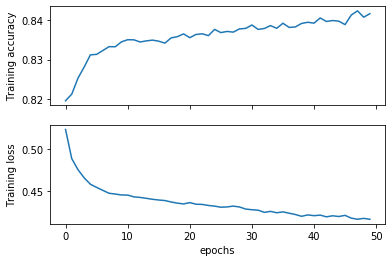

In [33]:
fig,ax = plt.subplots(2,sharex = True)

ax[0].plot(history_model_CNN.history['accuracy'],label="CNN")
ax[1].plot(history_model_CNN.history['loss'],label="CNN")

ax[1].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

    # keras LSTM:

In [34]:
X_train_reshape = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_validate_reshape = np.reshape(X_validate,(X_validate.shape[0],X_validate.shape[1],X_validate.shape[2]))
history_model_LSTM = model_LSTM.fit( X_train_reshape, y_train, 
                    batch_size=10,
                    validation_data=(X_validate_reshape, y_validate),
                    epochs=30)

Train on 40193 samples, validate on 19798 samples
Epoch 1/30
40193/40193 [==============================] - 92s 2ms/step - loss: 0.5537 - accuracy: 0.8197 - val_loss: 0.5028 - val_accuracy: 0.8202
Epoch 2/30
40193/40193 [==============================] - 91s 2ms/step - loss: 0.5058 - accuracy: 0.8203 - val_loss: 0.4954 - val_accuracy: 0.8208
Epoch 3/30
40193/40193 [==============================] - 91s 2ms/step - loss: 0.4995 - accuracy: 0.8205 - val_loss: 0.4922 - val_accuracy: 0.8206
Epoch 4/30
40193/40193 [==============================] - 91s 2ms/step - loss: 0.4959 - accuracy: 0.8206 - val_loss: 0.4856 - val_accuracy: 0.8207
Epoch 5/30
40193/40193 [==============================] - 91s 2ms/step - loss: 0.4926 - accuracy: 0.8206 - val_loss: 0.4844 - val_accuracy: 0.8209
Epoch 6/30
40193/40193 [==============================] - 91s 2ms/step - loss: 0.4925 - accuracy: 0.8203 - val_loss: 0.4837 - val_accuracy: 0.8207
Epoch 7/30
40193/40193 [==============================] - 91s 2ms/st

Text(0, 0.5, 'Training loss')

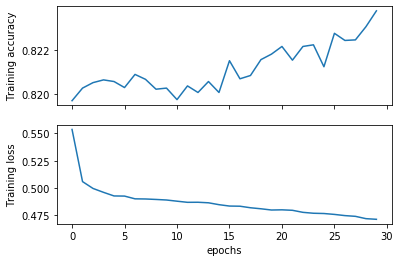

In [35]:
fig,ax = plt.subplots(2,sharex = True)

ax[0].plot(history_model_LSTM.history['accuracy'],label="LSTM")
ax[1].plot(history_model_LSTM.history['loss'],label="LSTM")

ax[1].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

2.4 ทำการ predict ค่าจากโมเดลทั้ง 2 แบบ (CNN, LSTM) ด้วยข้อมูล X_test, y_test ที่แบ่งไว้

    # keras CNN:

In [36]:
y_prediction_model_CNN = model_CNN.predict(X_test)
y_pred_single_model_CNN = [np.argmax(p) for p in y_prediction_model_CNN]
y_test_single_model_CNN =[np.argmax(p) for p in y_test]

    # keras LSTM:

In [37]:
X_test_reshape = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

y_prediction_model_LSTM = model_LSTM.predict(X_test_reshape)
y_pred_single_model_LSTM = [np.argmax(p) for p in y_prediction_model_LSTM]
y_test_single_model_LSTM =[np.argmax(p) for p in y_test]

2.5 คำนวณค่าตัววัดประสิทธิภาพของการทำนายจากโมเดล CNN และ LSTM โดยวัดค่า classification report/ confusion matrix

    # keras CNN:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       826
           1       0.59      0.27      0.37      4485
           2       0.86      0.98      0.92     24237

    accuracy                           0.85     29548
   macro avg       0.49      0.42      0.43     29548
weighted avg       0.80      0.85      0.81     29548



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


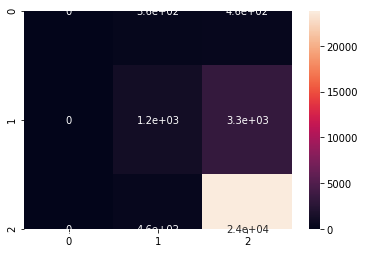

In [38]:
print(classification_report(y_test_single_model_CNN, y_pred_single_model_CNN))
sns.heatmap(confusion_matrix(y_test_single_model_CNN, y_pred_single_model_CNN), annot=True)

    # keras LSTM:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       826
           1       0.53      0.03      0.06      4485
           2       0.83      1.00      0.90     24237

    accuracy                           0.82     29548
   macro avg       0.45      0.34      0.32     29548
weighted avg       0.76      0.82      0.75     29548



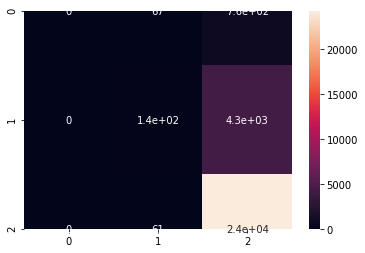

In [39]:
print(classification_report(y_test_single_model_LSTM, y_pred_single_model_LSTM))
sns.heatmap(confusion_matrix(y_test_single_model_LSTM, y_pred_single_model_LSTM), annot=True)